In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 250)

### Qasper 

In [41]:
!cd ..; python parse_tb.py

  0%|          | 0/143 [00:00<?, ?it/s]
2023-04-04 11:45:18.304717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 11:45:18.304773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [778]:
paths = ['../results/qasper.csv']
res_df = pd.concat([pd.read_csv(p) for p in paths])

In [779]:
res_df = res_df[res_df.task_name == 'qasper']

In [774]:
res_df = res_df[res_df.num_steps > 1000]

In [781]:
# res_df = res_df[res_df.num_steps.isin({5000})]
# res_df = res_df[res_df.best_valid_f1 > 5]

# res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(-1)
# res_df.sum_loss = res_df.sum_loss.fillna(False)
# res_df.segment_ordering = res_df.segment_ordering.fillna('regular')
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df.fillna('UNKNOWN', inplace=True)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])
# res_df = res_df[~((res_df.best_valid_f1 < 8.5) & (res_df.tag.apply(len) > 1))]

In [776]:
res_df.tag = res_df.tag.apply(lambda x: x.split('_sum_loss')[0] if 'sum_loss' in x else x)

In [768]:
res_df.loc[res_df.tag.apply(lambda x: 'mem_layers' in x and 'mem_loss' in x and 'V' not in x), 'tag'] = res_df.loc[res_df.tag.apply(lambda x: 'mem_layers' in x and 'mem_loss' in x and 'V' not in x), 'tag'].apply(lambda x: x.split('_mem_loss')[0]) 

In [769]:
res_df.loc[res_df.tag == '_mem_layers_sharedV2', 'tag'] = '_mem_layers_shared'

In [770]:
gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag', 'sum_loss']
metric_cols = ['best_valid_f1']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_f1  \
from_pretrained max_n_segments num_mem_tokens lr       lr_scheduler tag                                                sum_loss                  
t5-base         1              0              0.000050 linear                                                          False         19.185600   
                               1              0.000050 linear                                                          False         19.694800   
                                                                    _ln_end                                            False         19.542200   
                                                                    _mem_layers                                        False         19.298180   
                                                                    _mem_layers_shared                                 False         19.116233   
                                                                    _mem_layers_shared_last2                           False         19.027967   
                                                                    _scale_mem                                         False         19.168200   
                               10             0.000005 linear       _mem_loss_rc0.001                                  False         15.737500   
                                              0.000050 linear                                                          False         19.712025   
                                                                    _ilmV2_mem_layers_shared_mem_prefixV3              False         19.722000   
                                                                    _ilm_mem_layers_shared_mem_prefixV3                False         19.819099   
                                                                    _ln_end                                            False         18.424900   
                                                                    _mem_layers                                        False         20.034750   
                                                                    _mem_layers_mem_lossV2_rc0.001                     False         18.918550   
                                                                    _mem_layers_mem_lossV3_mask_decode_rc0.001         False         10.559650   
                                                                    _mem_layers_shared                                 False         18.862000   
                                                                    _mem_layers_shared_last2                           False         19.430766   
                                                                    _mem_loss_rc0.001                                  False         19.274500   
                                                                    _scale_mem                                         False         20.125200   
                               25             0.000050 linear       _mem_layers                                        False         19.049800   
                                                                    _mem_layers_shared                                 False         19.047099   
                                                                    _mem_layers_shared_last2                           False         19.634200   
                2              0              0.000050 linear                                                          False         11.010400   
                                                                    _repeat_question                                   False         20.948500   
                               1              0.000005 linear       _mem_loss_rc0.001                                  False          9.918500   
                                              0.000050 linear                                                          False         10.396100   
                                         

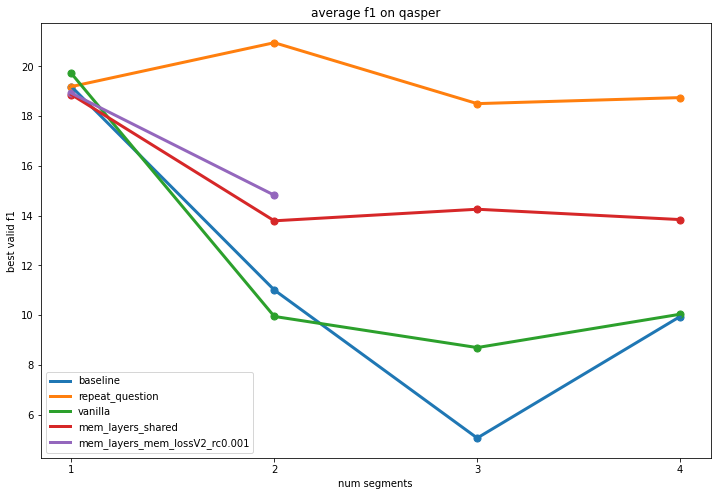

In [202]:

plt.figure(figsize=(12,8))
plt.title('average f1 on qasper')
# tag = '_mem_layers'

# tags = list(res_df.tag.unique())
tags = ['baseline', 
        '_repeat_question', 
        '_vanilla',
        '_mem_layers_shared',
        # '_ilmV2_mem_layers_shared',
        # '_ilm_mem_layers_shared_mem_prefixV3',
        '_mem_layers_mem_lossV2_rc0.001',
       ]
for tag in tags:
    num_mem = 10
    if tag in {'baseline', '_repeat_question'}:
        num_mem = 0
    # if tag in {'_mem_loss_rc0.1', '_mem_loss_rc0.05_prs_2000'}:
    #     num_mem = 1
        
    lr = 0.00005

    slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == tag)]
    slice = slice[slice.max_n_segments < 5]
    # slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens.isin({num_mem, 0})) & (res_df.tag == tag)]
    gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag']
    metric_cols = ['best_valid_f1']
    group_df = slice.groupby(gb_cols).mean()[metric_cols]
    group_df['std'] = slice.groupby(gb_cols).std()[['best_valid_f1']]
    group_df['n_runs'] = slice.groupby(gb_cols).count()['best_valid_f1']
    group_df['runs'] = slice.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
    group_df = group_df.reset_index()
    # if tag == '_repeat_question':
    #     break
    
    # group_df


    plt.scatter(group_df.max_n_segments, group_df.best_valid_f1, s=50)
    if not tag:
        tag = 'regular'
    elif tag != 'baseline':
        tag = tag[1:]
    plt.plot(group_df.max_n_segments.values, group_df.best_valid_f1.values, lw=3, label=tag)

# plt.legend(plots, tags)
plt.xlabel('num segments')
plt.xticks([1, 2, 3, 4])
plt.ylabel('best valid f1')
plt.legend()
plt.show()

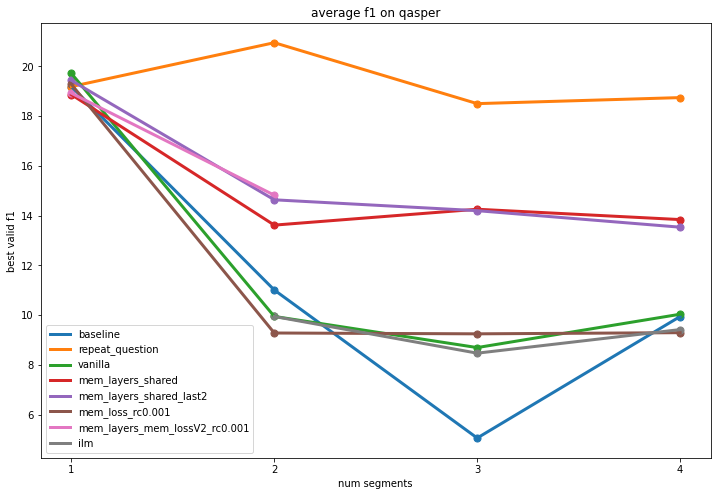

In [178]:

plt.figure(figsize=(12,8))
plt.title('average f1 on qasper')
# tag = '_mem_layers'

# tags = list(res_df.tag.unique())
tags = ['baseline', 
        '_repeat_question', 
        '_vanilla',
        # '_mem_layers',
        '_mem_layers_shared',
        '_mem_layers_shared_last2',
        '_mem_loss_rc0.001',
        # '_mem_loss_rc0.05_prs_2000',
        # '_mem_layers_shared_mem_loss_rc0.001',
        "_mem_layers_mem_lossV2_rc0.001",
        '_ilm'
       ]
for tag in tags:
    num_mem = 10
    if tag in {'baseline', '_repeat_question'}:
        num_mem = 0
    # if tag in {'_mem_loss_rc0.1', '_mem_loss_rc0.05_prs_2000'}:
    #     num_mem = 1
        
    lr = 0.00005

    slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == tag)]
    slice = slice[slice.max_n_segments < 5]
    # slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens.isin({num_mem, 0})) & (res_df.tag == tag)]
    gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag']
    metric_cols = ['best_valid_f1']
    group_df = slice.groupby(gb_cols).mean()[metric_cols]
    group_df['std'] = slice.groupby(gb_cols).std()[['best_valid_f1']]
    group_df['n_runs'] = slice.groupby(gb_cols).count()['best_valid_f1']
    group_df['runs'] = slice.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
    group_df = group_df.reset_index()
    # if tag == '_repeat_question':
    #     break
    
    # group_df


    plt.scatter(group_df.max_n_segments, group_df.best_valid_f1, s=50)
    if not tag:
        tag = 'regular'
    elif tag != 'baseline':
        tag = tag[1:]
    plt.plot(group_df.max_n_segments.values, group_df.best_valid_f1.values, lw=3, label=tag)

# plt.legend(plots, tags)
plt.xlabel('num segments')
plt.xticks([1, 2, 3, 4])
plt.ylabel('best valid f1')
plt.legend()
plt.show()

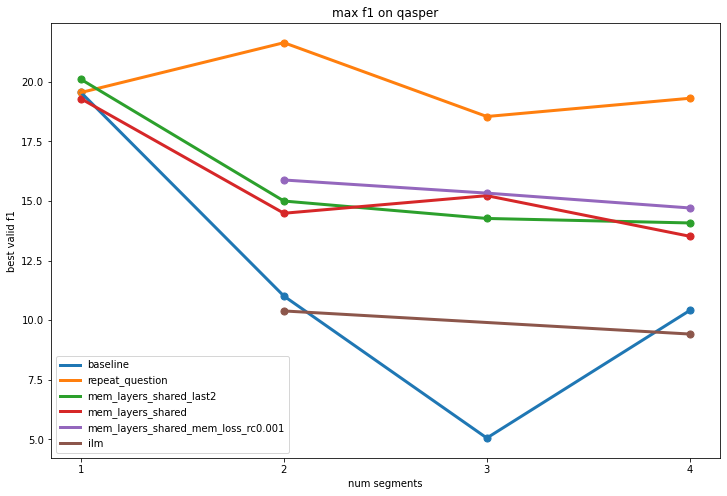

In [145]:

plt.figure(figsize=(12,8))
plt.title('max f1 on qasper')
# tag = '_mem_layers'

# tags = list(res_df.tag.unique())
tags = ['baseline', '_repeat_question', 
        # '_mem_layers',
       '_mem_layers_shared_last2', '_mem_layers_shared',
        # '_mem_loss_rc0.05_prs_2000',
        # '_mem_loss_rc0.001',
        '_mem_layers_shared_mem_loss_rc0.001',
       '_ilm'
       ]
for tag in tags:
    num_mem = 10
    if tag in {'baseline', '_repeat_question'}:
        num_mem = 0
    # if tag in {'_mem_loss_rc0.1', '_mem_loss_rc0.05_prs_2000'}:
    #     num_mem = 1
        
    lr = 0.00005

    slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == tag)]
    slice = slice[slice.max_n_segments < 5]
    # slice = res_df[(res_df.lr == lr) & (res_df.num_mem_tokens.isin({num_mem, 0})) & (res_df.tag == tag)]
    gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag']
    metric_cols = ['best_valid_f1']
    group_df = slice.groupby(gb_cols).max()[metric_cols]
    group_df['std'] = slice.groupby(gb_cols).std()[['best_valid_f1']]
    group_df['n_runs'] = slice.groupby(gb_cols).count()['best_valid_f1']
    group_df['runs'] = slice.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
    group_df = group_df.reset_index()
    # if tag == '_repeat_question':
    #     break
    
    # group_df


    plt.scatter(group_df.max_n_segments, group_df.best_valid_f1, s=50)
    if not tag:
        tag = 'regular'
    elif tag != 'baseline':
        tag = tag[1:]
    plt.plot(group_df.max_n_segments.values, group_df.best_valid_f1.values, lw=3, label=tag)

# plt.legend(plots, tags)
plt.xlabel('num segments')
plt.xticks([1, 2, 3, 4])
plt.ylabel('best valid f1')
plt.legend()
plt.show()

### Hyperpartisan

In [ ]:
 !cd ..;python parse_tb.py

In [207]:

# res_df[(res_df.from_pretrained == 'bert-base-cased') & (res_df.input_seq_len == 818)]

In [208]:
paths = ['../results/hyp_grid.csv',
         '../results/hyp.csv',
         '../results/hyp_new.csv',
         '../results/results_sbc/hyp_grid.csv'
        ]
         
         

In [ ]:
res_df = pd.concat([pd.read_csv(p) for p in paths])

In [ ]:
res_df_debug = pd.read_csv('../results/debug_hyp.csv')
res_df['sum_loss'] = False
res_df_debug['sum_loss'] = True
res_df = pd.concat((res_df, res_df_debug))
res_df.input_seg_size = res_df.input_seg_size.fillna(512)

In [ ]:
res_df = res_df.drop_duplicates()
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(0)
res_df = res_df[res_df.f1 > 0]

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss']
metric_cols = ['f1', 'best_valid_f1']

group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['f1_std'] = res_df.groupby(gb_cols).std()[['f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'f1':tuple}).f1.apply(lambda x: [round(i,2) for i in x])
# group_df

In [ ]:
# group_df.to_csv('../results/grouped/hyp.csv')

## contract-nli-curriculum

In [181]:
paths = [
         '../results/contract_nli_curriculum.csv'
        ]
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])

In [182]:
res_df['weigh_loss'] = res_df.model_cls.apply(lambda x: 'WeighSegLoss' in x)

In [188]:
res_df['mem_task_loss'] = res_df.model_cls == 'modeling_rmt.experimental:RMTEncoderTaskMemLoss'

In [184]:
res_df = res_df[res_df.model_path.apply(lambda x: 'cpt/' not in x)]
res_df = res_df[res_df.lr == 1e-05]
res_df = res_df[res_df.num_steps > 1000]

In [189]:

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'sum_loss', 'weigh_loss', 'mem_task_loss']
metric = 'best_valid_exact_match'
group_df = res_df.groupby(gb_cols).max()[[metric]]
group_df['std'] = res_df.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = res_df.groupby(gb_cols).agg({'tag':tuple})['tag']
group_df

best_valid_exact_match  \
from_pretrained max_n_segments num_mem_tokens sum_loss weigh_loss mem_task_loss                           
bert-base-cased 1              10             False    False      False                       71.001930   
                2              10             False    False      False                       72.034714   
                                              True     False      False                       71.730766   
                                                                  True                        72.543350   
                                                       True       False                       72.115387   
                3              10             False    False      False                       69.267822   
                                              True     False      False                       72.596153   
                                                                  True                        71.579964   
                                                       True       False                       70.673080   
                4              10             False    False      False                       54.720615   
                                              True     False      False                       72.307693   
                                                                  True                        72.254333   
                                                       True       False                       70.480766   
                5              10             False    False      False                       68.304428   
                                              True     False      False                       71.923080   
                                                                  True                        71.290947   
                                                       True       False                       71.346153   
                6              0              True     False      False                       55.202312   
                               10             False    False      False                       68.689789   
                                              True     False      False                       70.769234   
                                                                  True                        71.868980   
                                                       True       False                       70.000000   
                7              10             False    False      False                       57.418110   
                                              True     False      False                       70.288460   

                                                                                      std  \
from_pretrained max_n_segments num_mem_tokens sum_loss weigh_loss mem_task_loss             
bert-base-cased 1              10             False    False      False          0.000000   
                2              10             False    False      False          0.457802   
                                              True     False      False               NaN   
                                                                  True                NaN   
                                                       True       False               NaN   
                3              10             False    False      False               NaN   
                                              True     False      False               NaN   
                                                                  True                NaN   
                                                       True       False               NaN   
                4              10             False    False      False               NaN   
                                              True     False      False          0.883883   
                                                                  True                NaN

In [192]:
gdf = group_df.reset_index()
slices = [gdf[~gdf.sum_loss], gdf[gdf.sum_loss & (~gdf.weigh_loss) & (~gdf.mem_task_loss)], gdf[gdf.weigh_loss], gdf[gdf.mem_task_loss]]

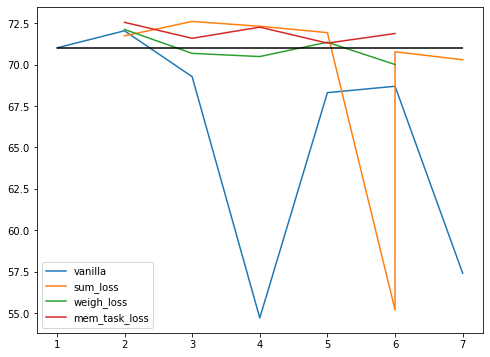

In [193]:
plt.figure(figsize=(8, 6))
for slc in slices:
    plt.plot(slc.max_n_segments, slc.best_valid_exact_match)
    

plt.hlines(71, xmin=1, xmax=7, color='k')
plt.legend(['vanilla', 'sum_loss', 'weigh_loss', 'mem_task_loss'])
plt.show()

# contract-nli

In [97]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:37.836345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:37.836403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [30]:
paths = ['../results/contract_nli.csv', 
         '../results/contract_nli-2.csv'
         # '../results/contract_nli_old.csv'
        ]
res_df = pd.concat([pd.read_csv(p) for p in paths])

In [31]:
# res_df = res_df[res_df.best_valid_exact_match > 55]
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(-1)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])

res_df.memory_layers = res_df.memory_layers.fillna('-')
res_df.reconstruction_loss_coef = res_df.reconstruction_loss_coef.fillna(0)
res_df['reconstruction_loss'] = res_df.reconstruction_loss_coef != 0
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['from_cpt'] = res_df.tag.apply(lambda x: 'from_cpt' in x)

res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(-1)
res_df.input_size.fillna(512, inplace=True)

# res_df = res_df[~((res_df.input_seq_len < 1500 ) & (res_df.max_n_segments > 2))]

In [32]:
res_df.loc[(res_df.input_seq_len < 1000) & (res_df.input_size == 512) & (res_df.max_n_segments > 1), 'max_n_segments'] = 1
res_df.loc[(res_df.input_seq_len < 1500) & (res_df.input_size == 512) & (res_df.max_n_segments > 2), 'max_n_segments'] = 2

In [33]:
res_df_full = res_df.copy()

fixed seq len smaller input size

In [34]:
slc = res_df_full[(res_df_full.input_seq_len < 513) | (res_df_full.max_n_segments == 1)]

slc = slc[~((slc.input_size == 512) & (slc.max_n_segments > 1))]
slc = slc[slc.num_mem_tokens != 1]


gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'reconstruction_loss', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
group_df

best_valid_exact_match  \
from_pretrained           max_n_segments num_mem_tokens memory_layers reconstruction_loss horizontal_memory input_size tag                                                       
bert-base-cased           1.0            0.0            -             False               False             512.0                                                    70.234650   
                                         10.0           -             False               False             512.0                                                    71.070393   
                                                                                                                       _from_cpt                                     70.360577   
                                                                                          True              512.0      _ilm_from_cpt                                 69.951923   
                                                                      True                False             512.0      _mlm_mem_loss_rc0.005_from_cpt                70.384617   
                                                        all           False               False             512.0      _memory_layers_shared                         69.720345   
                                                                                          True              512.0      _ilm_mem_layers_shared_from_cpt               70.192310   
                                                                      True                False             512.0      _mlm_mem_loss                                 69.961426   
                          2.0            10.0           -             False               False             263.0                                                    70.556089   
                                                                                          True              263.0      _ilm                                          70.217380   
                                                        all           False               False             263.0      _memory_layers_shared                         70.294360   
                          3.0            10.0           -             False               False             180.0                                                    68.627453   
                                                                                          True              180.0      _ilm                                          69.216881   
                                                        all           False               False             180.0      _memory_layers_shared                         65.369169   
                          4.0            10.0           -             False               False             138.0                                                    66.570234   
                                                                                          True              138.0      _ilm                                          61.928803   
                                                        all           False               False             138.0      _memory_layers_shared                         63.058957   
                          5.0            10.0           -             False               False             87.0                                                     53.173077   
                                                                                          True              87.0       _ilm                                          59.951921   
                                                        all           False               False             87.0       _memory_layers_shared                         54.567308   
                          8.0            10.0           -             False               False             50.0                                                     50.673077   
                                                          

In [486]:
# tags = [
#  '_baseline',
#  '_vanilla', 
#  # '_from_cpt',
#  # '_mlm_mem_loss',
#  '_ilm',
#  # '_ilm_from_cpt',
#  '_ilm_mem_layers_shared',
#  '_memory_layers_shared',
#  '_mlm_mem_loss_rc0.005',
#  # '_mlm_mem_loss_rc0.005_from_cpt',
#  '_mem_layers_shared_mlm_mem_loss_rc0.005',
#  # '_ilm_mem_layers_shared_from_cpt'
# ]

# slc.loc[(slc.tag == '') & (slc.num_mem_tokens == 0), 'tag'] = '_baseline'
# slc.loc[(slc.tag == '') & (slc.num_mem_tokens != 0), 'tag'] = '_vanilla'

# plt.figure(figsize=(12,8))
# plt.title(from_pretrained)
    
# for from_pretrained in np.unique(slc.from_pretrained):

    

#     for tag in tags:
#         num_mem = 10
#         if tag in {'_baseline'}:
#             num_mem = 0

#         slice = slc[(slc.from_pretrained == from_pretrained) & (slc.num_mem_tokens == num_mem) & (slc.tag == tag)]
#         if slice.shape[0] == 0:
#             continue
#         gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'tag']
#         metric = 'best_valid_exact_match'
#         # group_df = slice.groupby(gb_cols).mean()[[metric]]
#         group_df = slice.groupby(gb_cols).max()[[metric]]
#         group_df = group_df.reset_index()
#         # print(f'{from_pretrained} {tag[1:]}', group_df.shape)
#         if group_df.shape[0] < 3:
#             continue

#         max_n_segments = list(group_df.max_n_segments.values)
#         metric_values = list(group_df[metric].values)
#         if 1 not in max_n_segments and num_mem != 0:
#             max_n_segments = [1] + max_n_segments
#             value = res_df[(res_df.from_pretrained == from_pretrained) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == '_vanilla') & (res_df.max_n_segments == 1)][metric].mean()
#             metric_values = [value] + metric_values

#         plt.scatter(max_n_segments, metric_values, s=50)
#         plt.plot(max_n_segments, metric_values, lw=3, label=f'{from_pretrained} {tag[1:]}')

#     # plt.legend(plots, tags)
# plt.xlabel('num segments')
# plt.xticks(range(1, 16))
# plt.ylabel('best valid exact_match')
# plt.legend()
# plt.show()

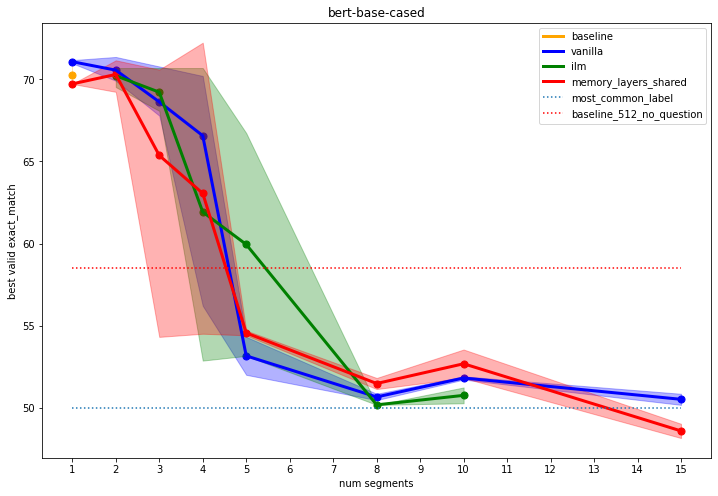

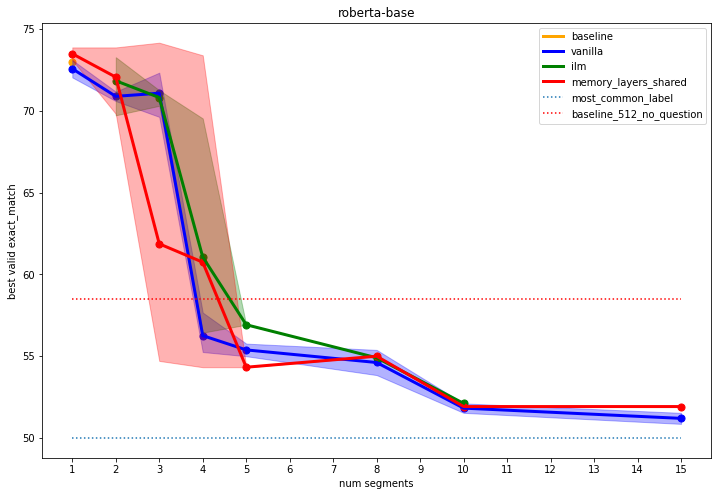

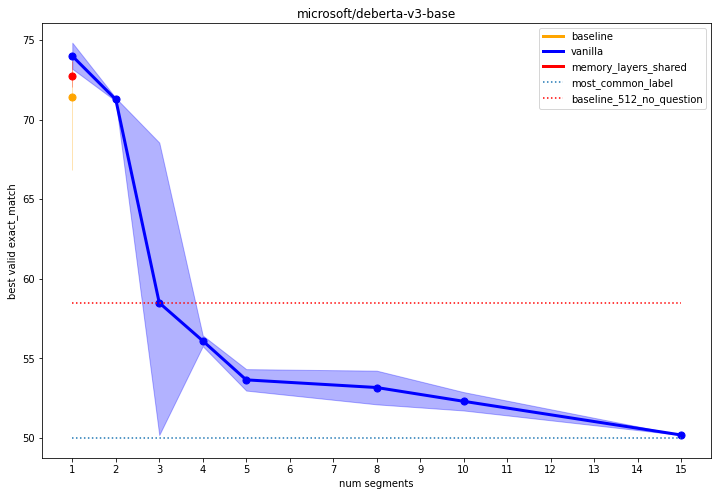

In [35]:
tags = [
 '_baseline',
 '_vanilla', 
 # '_from_cpt',
 # '_mlm_mem_loss',
 '_ilm',
 # '_ilm_from_cpt',
 # '_ilm_mem_layers_shared',
 '_memory_layers_shared',
 # '_mlm_mem_loss_rc0.005',
 # '_mlm_mem_loss_rc0.005_from_cpt',
 # '_mem_layers_shared_mlm_mem_loss_rc0.005',
 # '_ilm_mem_layers_shared_from_cpt'
]
slc = slc[slc[metric] > 10]
slc.loc[(slc.tag == '') & (slc.num_mem_tokens == 0), 'tag'] = '_baseline'
slc.loc[(slc.tag == '') & (slc.num_mem_tokens != 0), 'tag'] = '_vanilla'

most_common_score = 50
no_question_score = 58.5

models = ['bert-base-cased','roberta-base', 'microsoft/deberta-v3-base', ]
for from_pretrained in models:

    plt.figure(figsize=(12,8))
    plt.title(from_pretrained)

    colors = ['orange', 'blue', 'green', 'red', 'cyan']
    for i, tag in enumerate(tags):
        num_mem = 10
        if tag in {'_baseline'}:
            num_mem = 0

        slice = slc[(slc.from_pretrained == from_pretrained) & (slc.num_mem_tokens == num_mem) & (slc.tag == tag)]
        if slice.shape[0] == 0:
            continue
        gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'tag']
        metric = 'best_valid_exact_match'
        group_df = slice.groupby(gb_cols).mean()[[metric]]
        # group_df = slice.groupby(gb_cols).max()[[metric]]
        group_df['std'] = slice.groupby(gb_cols).std()[[metric]]
        group_df['max'] = slice.groupby(gb_cols).max()[[metric]]
        group_df['min'] = slice.groupby(gb_cols).min()[[metric]]
        group_df = group_df.reset_index()

        max_n_segments = list(group_df.max_n_segments.values)
        metric_values = list(group_df[metric].values)
        stds = list(group_df['std'].values)
        mins = list(group_df['min'].values)
        maxs = list(group_df['max'].values)
        # if 1 not in max_n_segments and num_mem != 0:
        #     max_n_segments = [1] + max_n_segments
        #     value = res_df[(res_df.from_pretrained == from_pretrained) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == '_vanilla') & (res_df.max_n_segments == 1)][metric].mean()
        #     metric_values = [value] + metric_values

        plt.scatter(max_n_segments, metric_values, s=50, color=colors[i])
        plt.plot(max_n_segments, metric_values, lw=3, label=tag[1:], color=colors[i])
        # plt.errorbar(max_n_segments, metric_values, stds, lw=4, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2)
        plt.fill_between(max_n_segments, mins, maxs, color=colors[i], alpha=0.3)

    
    plt.hlines(most_common_score, xmin=1, xmax=15, linestyle='dotted', label='most_common_label')
    plt.hlines(no_question_score, xmin=1, xmax=15, linestyle='dotted', label='baseline_512_no_question', color='r')

    # plt.legend(plots, tags)
    plt.xlabel('num segments')
    plt.xticks(range(1, 16))
    plt.ylabel('best valid exact_match')
    plt.legend()
    plt.show()

regular

In [40]:
slc = res_df[(res_df.input_size >= 512) & (res_df.best_valid_exact_match > 5) & ((res_df.best_valid_exact_match > 25) | (res_df.from_pretrained == 't5-base') | (res_df.num_mem_tokens == 0))]

In [41]:
slc.fillna('NA', inplace=True)


/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [807]:
# mean score
# gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag']
gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'lr', 'memory_layers', 'reconstruction_loss', 'horizontal_memory', 'from_cpt', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

### plot

In [475]:
res_df.loc[(res_df.tag == '') & (res_df.num_mem_tokens == 0), 'tag'] = '_baseline'
res_df.loc[(res_df.tag == '') & (res_df.num_mem_tokens != 0), 'tag'] = '_vanilla'

In [476]:
# plt.scatter(group_df.max_n_segments, group_df[metric], s=50)

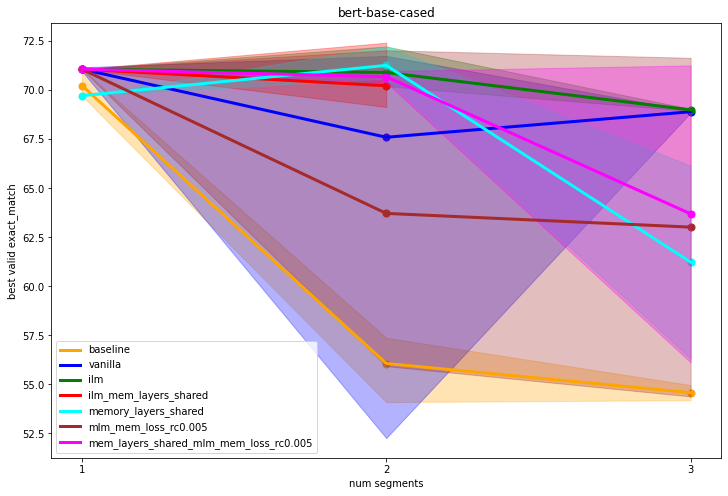

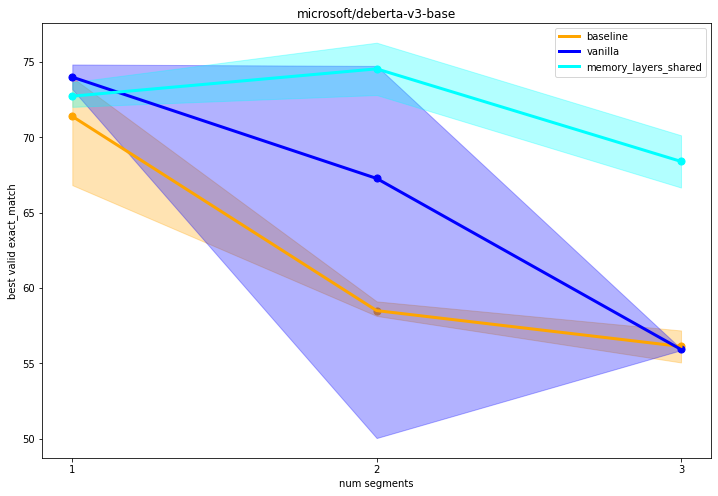

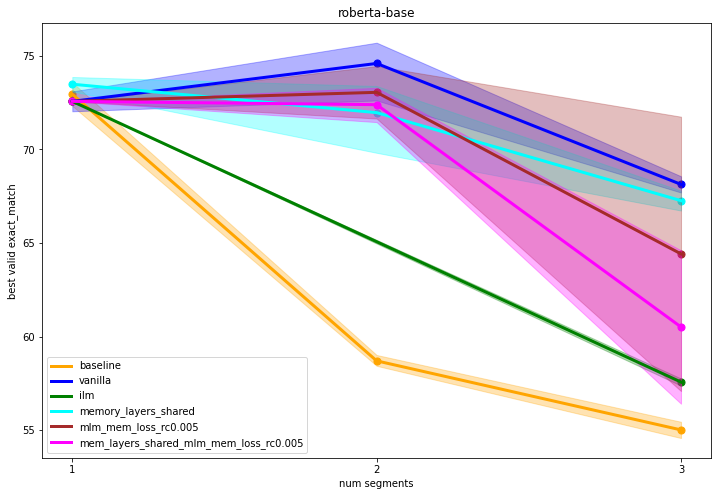

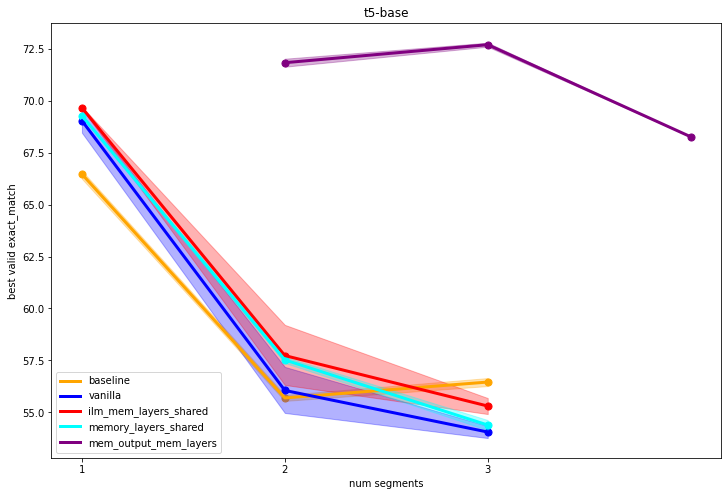

In [479]:
tags = [
 '_baseline',
 '_vanilla', 
 # '_from_cpt',
 # '_mlm_mem_loss',
 '_ilm',
 # '_ilm_from_cpt',
 '_ilm_mem_layers_shared',
 '_memory_layers_shared',
 '_mlm_mem_loss_rc0.005',
 # '_mlm_mem_loss_rc0.005_from_cpt',
 '_mem_layers_shared_mlm_mem_loss_rc0.005',
 '_mem_output_mem_layers',
 # '_ilm_mem_layers_shared_from_cpt'
]


slc = res_df[(res_df.input_size >= 512) & (res_df.best_valid_exact_match > 50)]

for from_pretrained in np.unique(res_df.from_pretrained):

    plt.figure(figsize=(12,8))
    plt.title(from_pretrained)

    colors = ['orange', 'blue', 'green', 'red', 'cyan', 'brown', 'magenta', 'purple']
    for i, tag in enumerate(tags):
        num_mem = 10
        if tag in {'_baseline'}:
            num_mem = 0
        if tag == '_mem_output_mem_layers':
            num_mem = 50

        slice = slc[(slc.from_pretrained == from_pretrained) & (slc.num_mem_tokens == num_mem) & (slc.tag == tag)]
        if slice.shape[0] == 0:
            continue
        gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'tag']
        metric = 'best_valid_exact_match'
        group_df = slice.groupby(gb_cols).mean()[[metric]]
        group_df['std'] = slice.groupby(gb_cols).std()[[metric]]
        group_df['max'] = slice.groupby(gb_cols).max()[[metric]]
        group_df['min'] = slice.groupby(gb_cols).min()[[metric]]
        group_df = group_df.reset_index()

        max_n_segments = list(group_df.max_n_segments.values)
        metric_values = list(group_df[metric].values)
        stds = list(group_df['std'].values)
        mins = list(group_df['min'].values)
        maxs = list(group_df['max'].values)
        if 1 not in max_n_segments and num_mem != 0:
            max_n_segments = [1] + max_n_segments
            value = res_df[(res_df.from_pretrained == from_pretrained) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == '_vanilla') & (res_df.max_n_segments == 1)][metric].mean()
            metric_values = [value] + metric_values
            mins = [value] + mins
            maxs = [value] + maxs

        plt.scatter(max_n_segments, metric_values, s=50, color=colors[i])
        plt.plot(max_n_segments, metric_values, lw=3, label=tag[1:], color=colors[i])
        # plt.errorbar(max_n_segments, metric_values, stds, lw=4, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2)
        plt.fill_between(max_n_segments, mins, maxs, color=colors[i], alpha=0.3)


    # plt.legend(plots, tags)
    plt.xlabel('num segments')
    plt.xticks([1, 2, 3])
    plt.ylabel('best valid exact_match')
    plt.legend()
    plt.show()

### transpose results

In [12]:
conditions = []
labels = []

conditions.append((res_df.memory_layers == '-') & (~res_df.reconstruction_loss) & (~res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('baseline')

conditions.append((res_df.memory_layers == 'all') & (~res_df.reconstruction_loss) & (~res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('memory_layers_shared')

conditions.append((res_df.memory_layers == '-') & (~res_df.reconstruction_loss) & (res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('horizontal_memory')

conditions.append((res_df.memory_layers == 'all') & (~res_df.reconstruction_loss) & (res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('horizontal_memory + mem_layers')

conditions.append((res_df.memory_layers == '-') & (res_df.reconstruction_loss) & (~res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('horizontal_memory')

conditions.append((res_df.memory_layers == 'all') & (res_df.reconstruction_loss) & (~res_df.horizontal_memory) & (~res_df.from_cpt))
labels.append('horizontal_memory + mem_layers')

conditions.append((res_df.memory_layers == '-') & (~res_df.reconstruction_loss) & (~res_df.horizontal_memory) & (res_df.from_cpt))
labels.append('baseline_from_cpt')

In [21]:
slice = res_df[res_df.num_mem_tokens == 10]
gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens']
# 'memory_layers', 'reconstruction_loss', 'horizontal_memory', 'from_cpt']
metric = 'best_valid_exact_match'
group_df = slice.groupby(gb_cols).max()[[metric]]
group_df.columns = ['max']
# group_df['std'] = res_df.groupby(gb_cols).std()[[metric]]
# group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric]
# group_df['runs'] = res_df.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
# group_df['tags'] = res_df.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

In [22]:
# for label, condition in zip(labels, conditions):
#     condition_gb = res_df[condition].groupby(gb_cols).mean()[[metric]]
#     group_df.loc[condition_gb.index, label] = condition_gb.values

In [24]:
# baseline
for label, condition in zip(labels[:1], conditions[:1]):
    condition_gb = slice[condition].groupby(gb_cols).mean()[[metric]]
    group_df.loc[condition_gb.index, label] = condition_gb.values
    
for label, condition in zip(labels[1:], conditions[1:]):
    condition_gb = slice[condition].groupby(gb_cols).mean()[[metric]]
    group_df.loc[condition_gb.index, label] = condition_gb.values[:, 0] - group_df.loc[condition_gb.index, 'baseline'].values
    
group_df

/tmp/ipykernel_1608001/3390217298.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  condition_gb = slice[condition].groupby(gb_cols).mean()[[metric]]
/tmp/ipykernel_1608001/3390217298.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  condition_gb = slice[condition].groupby(gb_cols).mean()[[metric]]


max   baseline  \
from_pretrained           max_n_segments num_mem_tokens                         
bert-base-cased           1              10              72.211540  71.166824   
                          2              10              72.420441  71.391836   
                          3              10              70.877533  69.575703   
microsoft/deberta-v3-base 1              10              74.831245  73.995501   
                          2              10              76.277725  73.987463   
                          3              10              71.166824  69.165863   
roberta-base              1              10              73.866920  72.565090   
                          2              10              75.699135  74.590164   
t5-base                   1              10              69.720299  69.045300   
                          2              10              57.666302  56.026999   
                          3              10              59.209301  57.184200   

                                                         memory_layers_shared  \
from_pretrained           max_n_segments num_mem_tokens                         
bert-base-cased           1              10                         -1.446480   
                          2              10                         -0.128578   
                          3              10                               NaN   
microsoft/deberta-v3-base 1              10                         -0.514308   
                          2              10                          0.554487   
                          3              10                               NaN   
roberta-base              1              10                          0.916103   
                          2              10                         -2.627771   
t5-base                   1              10                          0.241100   
                          2              10                          1.350000   
                          3              10                          0.482101   

                                                         horizontal_memory  \
from_pretrained           max_n_segments num_mem_tokens                      
bert-base-cased           1              10                            NaN   
                          2              10                      -0.466089   
                          3              10                     -13.066542   
microsoft/deberta-v3-base 1              10                            NaN   
                          2              10                            NaN   
                          3              10                            NaN   
roberta-base              1              10                            NaN   
                          2              10                      -1.542912   
t5-base                   1              10                            NaN   
                          2              10                            NaN   
                          3              10                            NaN   

                                                         horizontal_memory + mem_layers  \
from_pretrained           max_n_segments num_mem_tokens                                   
bert-base-cased           1              10                                   -1.205399   
                          2              10                                   -0.827709   
                          3              10                                    0.048210   
microsoft/deberta-v3-base 1              10                                         NaN   
                          2              10                                         NaN   
                          3              10                                         NaN   
roberta-base              1              10                                         NaN   
                          2              10                                   -2.201866   
t5-base                   1   

### max

In [78]:

# # gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'lr_scheduler', 'tag']
# gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'memory_layers', 'reconstruction_loss']
# metric = 'best_valid_exact_match'
# group_df = res_df.groupby(gb_cols).max()[[metric]]
# group_df['std'] = res_df.groupby(gb_cols).std()[[metric]]
# group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric]
# group_df['runs'] = res_df.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
# group_df

In [48]:
# group_df.to_csv('../results/grouped/cnli_sum_loss.csv')

# babi-long reasoning


In [201]:
!cd ..; python parse_tb.py

  0%|          | 0/58 [00:00<?, ?it/s]
2023-04-10 16:17:47.153621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 16:17:47.153659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  0%|          | 0/115 [00:00<?, ?it/s]


In [144]:
res_df = pd.read_csv('../results/babilong_reasoning.csv')

In [145]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [147]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

In [148]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [152]:
# group_df

In [149]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                   \
eval_segment                           1          2          3          4    
checkpoint_segment                                                           
1                               18.312559  13.854266  16.490892  17.401726   
2                               14.285714  16.778524  14.285714  17.209970   
3                               10.930010  15.675935  12.128475   9.060403   
4                               18.791946  16.922338  10.546500   8.197507   
5                               19.175455   9.827421   4.602109   3.739214   
6                               23.633749  18.120806  15.915628  16.347076   
7                               26.797699  30.728668  30.680729  30.201342   

                                                                           \
eval_segment               5          6          7          8          9    
checkpoint_segment                                                          
1                   17.257910  16.251198  16.490892  15.819751  15.388303   
2                   16.826462  17.497602  16.586769  17.545542  18.168743   
3                    6.711410   5.992330   6.136146   8.101630   8.581017   
4                    4.985619   3.787153   4.937680   5.848514   8.341323   
5                    3.163950   4.314477   4.218600   4.026845   3.547459   
6                   16.874401  13.710450  15.915628  14.573346  16.251198   
7                   32.070950  34.084373  31.975073  33.317352  34.899330   

                                                                           \
eval_segment               10         11         12         13         14   
checkpoint_segment                                                          
1                   17.497602  17.066154  16.299137  17.209970  17.305849   
2                   17.881113  21.140940  23.202301  22.243528  25.790987   
3                    9.156280  10.786194  11.073826  11.936721  11.217642   
4                    6.375839   5.656759   6.327900   6.711410   6.855225   
5                    4.074784   3.403643   3.691275   3.595398   4.122723   
6                   14.765100  16.059444  16.299137  16.826462  17.257910   
7                   33.125599  31.927134  32.406521  32.646214  33.077660   

                               
eval_segment               15  
checkpoint_segment             
1                   18.887823  
2                   26.845638  
3                   10.930010  
4                    6.519655  
5                    3.883030  
6                   16.586769  
7                   32.790028

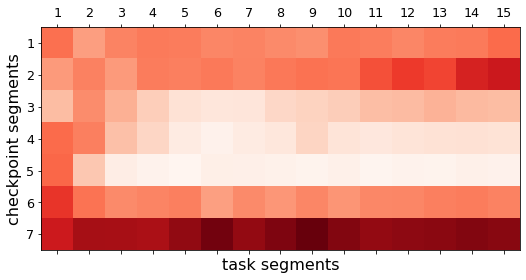

In [150]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

# babi-long random V2


In [24]:
!cd ..; python parse_tb.py

  0%|          | 0/58 [00:00<?, ?it/s]
2023-04-11 13:04:09.364386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 13:04:09.364430: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  0%|          | 0/15 [00:00<?, ?it/s]


In [25]:
res_df = pd.read_csv('../results/babilong_random_v2.csv')

In [26]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])
res_df = res_df[res_df.num_steps > 990]

In [27]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

In [28]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [29]:
group_df

best_valid_exact_match  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                                     
bert-base-cased 1              10                           False             512        _from_cpt_0-1              100.000000   
                2              10                           False             512        _from_cpt_1-2              100.000000   
                3              10                           False             512        _from_cpt_2-3              100.000000   
                4              10                           False             512        _from_cpt_3-4               99.760536   
                5              10                           False             512        _from_cpt_4-5               99.952110   
                6              10                           False             512        _from_cpt_5-6               99.952110   
                7              10                           False             512        _from_cpt_6-7               99.952110   
                8              10                           False             512        _from_cpt_7-8              100.000000   

                                                                                                        std  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                  
bert-base-cased 1              10                           False             512        _from_cpt_0-1  0.0   
                2              10                           False             512        _from_cpt_1-2  NaN   
                3              10                           False             512        _from_cpt_2-3  NaN   
                4              10                           False             512        _from_cpt_3-4  NaN   
                5              10                           False             512        _from_cpt_4-5  NaN   
                6              10                           False             512        _from_cpt_5-6  NaN   
                7              10                           False             512        _from_cpt_6-7  NaN   
                8              10                           False             512        _from_cpt_7-8  NaN   

                                                                                                        n_runs  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                     
bert-base-cased 1              10                           False             512        _from_cpt_0-1       2   
                2              10                           False             512        _from_cpt_1-2       1   
                3              10                           False             512        _from_cpt_2-3       1   
                4              10                           False             512        _from_cpt_3-4       1   
                5              10                           False             512        _from_cpt_4-5       1   
                6              10                           False             512        _from_cpt_5-6       1   
                7              10                           False             512        _from_cpt_6-7       1   
                8              10                           False             512        _from_cpt_7-8       1   

                                                                                                                  runs  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                             
bert-base-cased 1              10                           False             512        _from_cpt_0-1  [100.0, 100.0]   
                2              10                           False             512        _from_cpt_1-2         [100.0]   
                3              10                           Fal

In [8]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

checkpoint_segment


In [9]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

ZeroDivisionError: division by zero

# babi-long random


In [49]:
!cd ..; python parse_tb.py

  0%|          | 0/161 [00:00<?, ?it/s]
2023-04-04 16:25:36.857275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 16:25:36.857339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [167]:
res_df = pd.read_csv('../results/babilong_random.csv')

In [168]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [169]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

In [170]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [171]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                                   100.0   16.347076   18.839886   15.771812   
2                                   100.0  100.000000   97.890701   83.844681   
3                                   100.0  100.000000  100.000000  100.000000   
4                                   100.0  100.000000  100.000000  100.000000   
5                                   100.0  100.000000  100.000000  100.000000   
6                                   100.0  100.000000  100.000000  100.000000   
7                                   100.0  100.000000  100.000000  100.000000   

                                                                    \
eval_segment              5           6           7           8      
checkpoint_segment                                                   
1                    15.052732   16.874401   16.778524   16.395014   
2                    77.852348   68.887825   52.301056   44.630871   
3                    98.657715   97.986580   96.979866   95.206139   
4                   100.000000  100.000000  100.000000  100.000000   
5                    99.952065  100.000000  100.000000  100.000000   
6                    99.952065  100.000000   99.808243  100.000000   
7                   100.000000   99.952065   99.808243   99.952065   

                                            ...                          \
eval_segment              9           10    ...        12          13     
checkpoint_segment                          ...                           
1                    16.155321   16.970278  ...   16.970278   18.552254   
2                    38.302971   33.077660  ...   22.627037   21.524448   
3                    87.583893   78.523491  ...   60.450623   52.684563   
4                   100.000000  100.000000  ...  100.000000  100.000000   
5                    99.904121   99.952065  ...   99.952065   99.952065   
6                    99.904121   99.952065  ...   99.904121  100.000000   
7                   100.000000   99.952065  ...   99.952065   99.952065   

                                                                             \
eval_segment              14          15         32         64         128    
checkpoint_segment                                                            
1                    16.634708   16.251198        NaN        NaN        NaN   
2                    21.093000   17.162033        NaN        NaN        NaN   
3                    46.644295   42.090126        NaN        NaN        NaN   
4                   100.000000  100.000000        NaN        NaN        NaN   
5                   100.000000  100.000000        NaN        NaN        NaN   
6                   100.000000  100.000000        NaN        NaN        NaN   
7                   100.000000  100.000000  99.952065  99.856186  99.472672   

                                                     
eval_segment             256        512        1024  
checkpoint_segment                                   
1                         NaN        NaN        NaN  
2                         NaN        NaN        NaN  
3                         NaN        NaN        NaN  
4                         NaN        NaN        NaN  
5                         NaN        NaN        NaN  
6                         NaN        NaN        NaN  
7                   98.849472  97.603065  97.746887  

[7 rows x 21 columns]

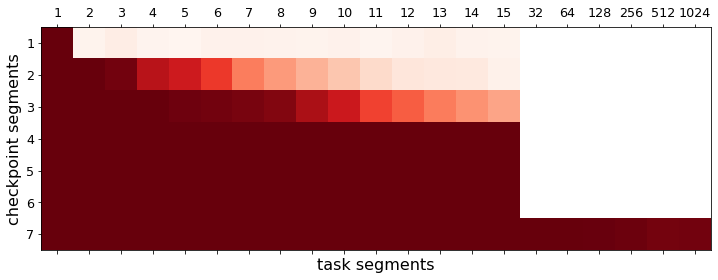

In [172]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

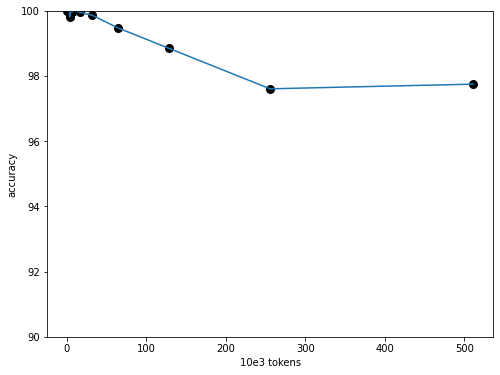

In [173]:
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == 7]

plt.figure(figsize=(8, 6))
# x_values = np.log10(slice.eval_segment * 499)
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
plt.scatter(x_values, y_values, lw=3, color='k')
plt.plot(x_values, y_values)
plt.ylim(90, 100)
plt.xlabel('10e3 tokens')
plt.ylabel('accuracy')
plt.show()

# babi-long 

In [199]:
!cd ..; python parse_tb.py

  0%|          | 0/115 [00:00<?, ?it/s]


In [237]:
res_df = pd.read_csv('../results/babilong.csv')

In [238]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


### various task size

In [239]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [241]:
eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
# gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]

/tmp/ipykernel_448167/1486924716.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()


In [242]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                         1    2    3    4    5    6    7    8      
checkpoint_segment                                                             
1                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
2                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
3                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
4                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
5                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
6                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
7                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   

                              ...                                          \
eval_segment       9    10    ... 17   18   19   20   32   64   128  256    
checkpoint_segment            ...                                           
1                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
2                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
3                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
4                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
5                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
6                   2.0  2.0  ...  2.0  2.0  2.0  2.0  NaN  NaN  NaN  NaN   
7                   2.0  2.0  ...  2.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0   

                              
eval_segment       512  1024  
checkpoint_segment            
1                   NaN  NaN  
2                   NaN  NaN  
3                   NaN  NaN  
4                   NaN  NaN  
5                   NaN  NaN  
6                   NaN  NaN  
7                   1.0  1.0  

[7 rows x 26 columns]

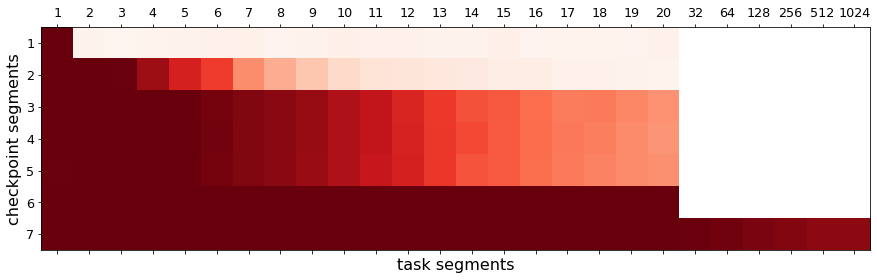

In [179]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

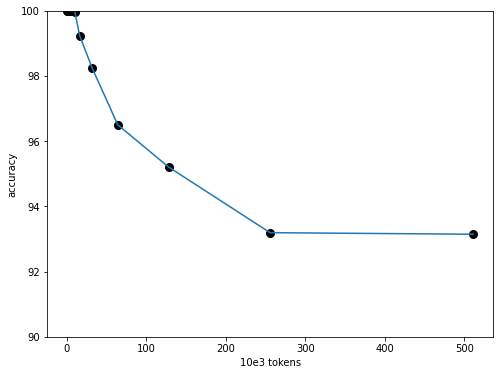

In [180]:
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == 7]

plt.figure(figsize=(8, 6))
# x_values = np.log10(slice.eval_segment * 499)
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
plt.scatter(x_values, y_values, lw=3, color='k')
plt.plot(x_values, y_values)
plt.ylim(90, 100)
plt.xlabel('10e3 tokens')
plt.ylabel('accuracy')
plt.show()

### fixed task length


In [755]:
# slc = res_df_full[(res_df_full.input_seq_len < 513) | (res_df_full.max_n_segments == 1)]

# slc = slc[~((slc.input_size == 512) & (slc.max_n_segments > 1))]
# slc = slc[slc.num_mem_tokens != 1]
slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_size < 512)]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

In [756]:
group_df['solved_pct'] = group_df.runs.apply(lambda x: (np.array(x) > 99).mean())

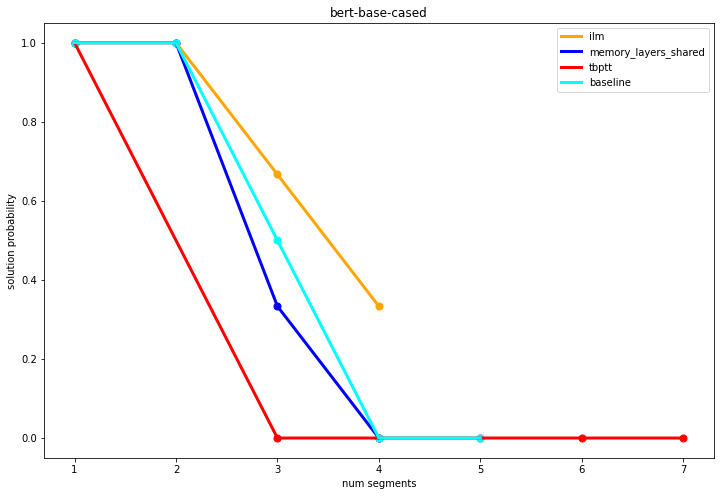

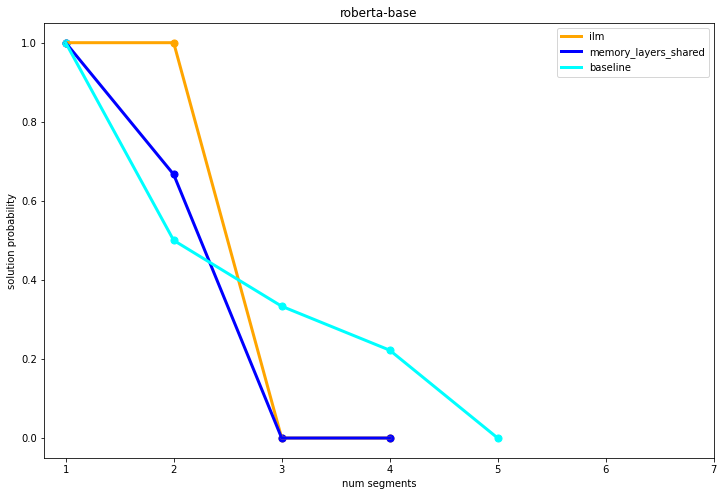

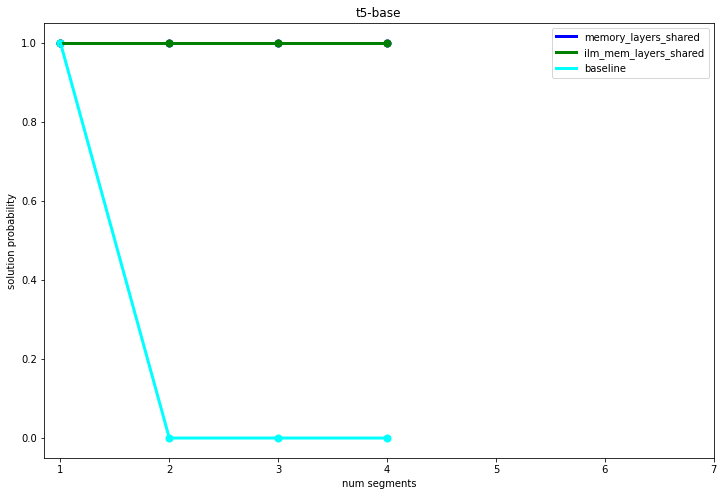

In [757]:
tags = ['_ilm', '_memory_layers_shared', '_ilm_mem_layers_shared', '_tbptt', '']


slc = res_df.copy()
slc.loc[slc.tag.apply(lambda x: 'tbptt' in x), 'tag'] = '_tbptt'
slc = slc[slc.max_n_segments <= 7]
for from_pretrained in np.unique(res_df.from_pretrained):

    plt.figure(figsize=(12,8))
    plt.title(from_pretrained)

    colors = ['orange', 'blue', 'green', 'red', 'cyan', 'brown', 'magenta', 'pink']
    for i, tag in enumerate(tags):
        num_mem = 10
        if tag in {'_baseline'}:
            num_mem = 0

        slice = slc[(slc.from_pretrained == from_pretrained) & (slc.num_mem_tokens == num_mem) & (slc.tag == tag)]
        if slice.shape[0] == 0:
            continue
        gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'tag']
        metric = 'best_valid_exact_match'
        group_df = slice.groupby(gb_cols).mean()[[metric]]
        # group_df['std'] = slice.groupby(gb_cols).std()[[metric]]
        # group_df['max'] = slice.groupby(gb_cols).max()[[metric]]
        # group_df['min'] = slice.groupby(gb_cols).min()[[metric]]
        group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
        group_df['solved_pct'] = group_df.runs.apply(lambda x: (np.array(x) > 99).mean())        
        group_df = group_df.reset_index()

        max_n_segments = list(group_df.max_n_segments.values)
        metric_values = list(group_df['solved_pct'].values)
        # stds = list(group_df['std'].values)
        # mins = list(group_df['min'].values)
        # maxs = list(group_df['max'].values)
        # if 1 not in max_n_segments and num_mem != 0:
        #     max_n_segments = [1] + max_n_segments
        #     value = res_df[(res_df.from_pretrained == from_pretrained) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == '_vanilla') & (res_df.max_n_segments == 1)][metric].mean()
        max_n_segments = [1] + max_n_segments
        metric_values = [1] + metric_values
            # mins = [value] + mins
            # maxs = [value] + maxs
        if tag == '':
            tag = '_baseline'

        plt.scatter(max_n_segments, metric_values, s=50, color=colors[i])
        plt.plot(max_n_segments, metric_values, lw=3, label=tag[1:], color=colors[i])
        # plt.errorbar(max_n_segments, metric_values, stds, lw=4, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2)
        # plt.fill_between(max_n_segments, mins, maxs, color=colors[i], alpha=0.3)


    # plt.legend(plots, tags)
    plt.xlabel('num segments')
    plt.xticks(range(1, 8))
    plt.ylabel('solution probability')
    plt.legend()
    plt.show()

#### curriculum eval

regular

In [386]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]


In [387]:
# import math
# print(' '.join([str(math.ceil(500 / i + 13)) for i in range(1, 26)]))
# print(' '.join([str(i) for i in range(1, 26)]))

In [388]:
# eval_df[eval_df['eval_segment'] == 15]

In [385]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                             ...     \
eval_segment                           1  2  3  4  5  6  7  8  9  10  ... 16   
checkpoint_segment                                                    ...      
1                                       6  2  2  2  2  2  2  1  1  1  ...  1   
2                                       6  2  2  2  2  2  2  1  1  1  ...  1   
3                                       5  3  3  3  3  3  3  2  2  2  ...  2   
4                                       5  3  3  3  3  3  3  2  2  2  ...  2   
5                                       5  3  3  3  3  3  3  2  2  2  ...  2   
6                                       5  3  3  3  3  3  3  2  2  2  ...  2   
7                                       5  3  3  3  3  3  2  2  2  2  ...  2   
8                                       5  3  3  3  3  3  2  2  2  2  ...  2   

                                               
eval_segment       17 18 19 20 21 22 23 24 25  
checkpoint_segment                             
1                   1  2  1  1  2  3  1  1  1  
2                   1  2  1  1  2  3  1  1  1  
3                   2  2  2  3  4  4  2  2  2  
4                   2  2  2  3  3  4  2  2  2  
5                   2  2  2  3  2  3  2  2  2  
6                   2  2  2  3  2  3  2  2  2  
7                   2  2  2  3  2  2  2  2  2  
8                   2  2  2  3  2  2  2  2  2  

[8 rows x 25 columns]

In [389]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                           1           2           3           4    
checkpoint_segment                                                              
1                              100.000000   16.738506   15.972222   16.091954   
2                               59.027778  100.000000   90.086208   81.896553   
3                               66.886973  100.000000   99.936145   99.808428   
4                               67.030653  100.000000  100.000000  100.000000   
5                               67.107280  100.000000  100.000000  100.000000   
6                               67.270115  100.000000  100.000000  100.000000   
7                               67.126436  100.000000  100.000000  100.000000   
8                               67.183909  100.000000  100.000000  100.000000   

                                                                               \
eval_segment                5           6           7           8          9    
checkpoint_segment                                                              
1                    16.858237   16.379311   17.073755   16.235632  15.565134   
2                    66.738504   54.765324   48.108238   29.741379  23.850574   
3                    93.215197   82.120051   66.730525   52.897509  47.078545   
4                    99.744573   98.930397   93.805875   77.131227  72.749041   
5                    99.984037   99.952108   99.824394   99.233719  97.030651   
6                   100.000000  100.000000  100.000000  100.000000  99.760536   
7                   100.000000  100.000000  100.000000  100.000000  99.808430   
8                   100.000000  100.000000  100.000000  100.000000  99.808430   

                               ...                                   \
eval_segment               10  ...         16         17         18   
checkpoint_segment             ...                                    
1                   16.379311  ...  17.049809  16.283525  16.379311   
2                   27.059387  ...  18.821838  18.438698  18.438698   
3                   41.139847  ...  29.358237  27.514368  27.394636   
4                   67.672415  ...  41.738505  38.553640  37.547893   
5                   94.612072  ...  66.355364  58.165710  58.405172   
6                   99.066093  ...  87.308430  86.182949  84.339081   
7                   99.066093  ...  87.595787  84.530651  85.057472   
8                   99.305557  ...  87.835251  85.727970  85.129311   

                                                                           \
eval_segment               19         20         21         22         23   
checkpoint_segment                                                          
1                   17.337164  16.379311  15.900383  16.251596  16.858238   
2                   16.379311  18.295019  18.199234  15.964240  17.097702   
3                   23.491380  26.181354  23.395594  22.617337  21.360153   
4                   32.207854  35.265006  30.220306  26.556513  27.514367   
5                   55.124521  46.120689  51.843868  52.474458  47.725096   
6                   81.704983  87.468071  80.531609  71.807153  76.963604   
7                   82.351532  87.755427  80.771072  77.035440  76.460728   
8                   81.800766  87.484037  80.292145  77.179117  75.838121   

                                          
eval_segment               24         25  
checkpoint_segment                        
1                   15.900383  17.528736  
2                   18.247126  15.996168  
3                   20.617817  22.820881  
4                   28.448276  28.113027  
5                   43.773947  46.839081  
6                   69.492336  71.719347  
7                   70.354404  74.832376  
8                   70.713604  71.479883  

[8 rows x 25 columns]

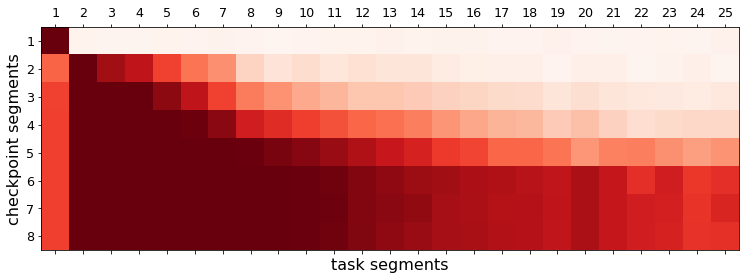

In [390]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=range(1, table.shape[1]+1), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=range(1, table.shape[0]+1), fontsize=fs*0.8)
plt.show()

sum loss

In [391]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & ((res_df.sum_loss) | (res_df.tag.apply(lambda x: 'sum_loss' in x)) | res_df.tag.apply(lambda x: x[:3] == '_1-'))].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]

In [392]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                           1    2    3    4    5    6    7    8    
checkpoint_segment                                                             
1                                     6.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
2                                     3.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN   
3                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
4                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
5                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
6                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
7                                     3.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0   
8                                     3.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0   

                              ...                                          \
eval_segment         9    10  ...   16   17   18   19   20   21   22   23   
checkpoint_segment            ...                                           
1                   1.0  1.0  ...  1.0  1.0  2.0  1.0  1.0  2.0  3.0  1.0   
2                   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0   
4                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
5                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
6                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
7                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
8                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   

                              
eval_segment         24   25  
checkpoint_segment            
1                   1.0  1.0  
2                   NaN  NaN  
3                   1.0  1.0  
4                   1.0  1.0  
5                   1.0  1.0  
6                   1.0  1.0  
7                   1.0  1.0  
8                   1.0  1.0  

[8 rows x 25 columns]

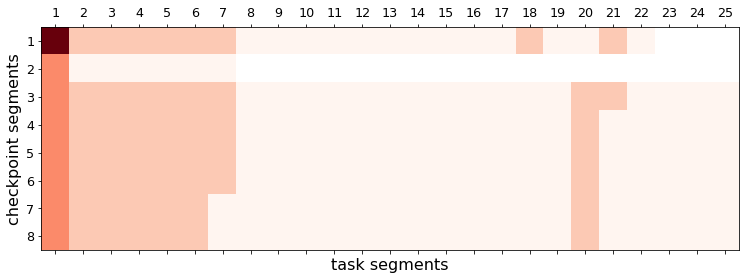

In [371]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

### wikitext


In [96]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:16.453394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:16.453468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df = pd.read_csv('../results/wikitext.csv')

In [93]:
df.num_mem_tokens = df.num_mem_tokens.fillna('NA')
df.share_memory_layers = df.share_memory_layers.fillna(False)
df.k2 = df.k2.fillna(1)
df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
df.freeze_model_weights = df.freeze_model_weights.fillna(False)

In [94]:
df = df[df.best_valid_loss < 3]

In [95]:
gb_cols = ['from_pretrained', 'model_cls', 'num_mem_tokens', 'lr', 'lr_scheduler', 'k2', 'freeze_model_weights', 'from_cpt']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
from_pretrained model_cls                                          num_mem_tokens lr       lr_scheduler         k2   freeze_model_weights from_cpt                    
gpt2            modeling_rmt.language_modeling:RMTDecoderLMHead    10.0           0.000005 linear                1.0 False                False            2.696082   
                                                                   25.0           0.000005 constant_with_warmup  1.0 False                False            2.693921   
                                                                                                                 2.0 False                False            2.693101   
                                                                                           linear                1.0 False                False            2.700119   
                                                                                                                 2.0 False                False            2.697857   
                modeling_rmt.language_modeling:RMTDecoderMemory... 10.0           0.000001 linear                1.0 False                False            2.857818   
                                                                                                                 2.0 False                False            2.839722   
                                                                                  0.000005 linear                1.0 False                False            2.724896   
                                                                                                                 2.0 False                False            2.709527   
                                                                                  0.000010 constant_with_warmup  1.0 True                 True             2.764399   
                                                                                           linear                1.0 False                False            2.698679   
                                                                                                                                          True             2.695399   
                                                                                                                 2.0 False                False            2.684810   
                                                                                  0.000100 constant_with_warmup  1.0 True                 True             2.783597   
                modeling_rmt:RMTDecoderForCausalLM                 10.0           0.000005 constant_with_warmup  1.0 False                False            2.692568   
                                                                                                                 2.0 False                False            2.688242   
                                                                                                                 3.0 False                False            2.688129   
                                                                                  0.000010 constant_with_warmup  1.0 False                False            2.696101   
                                                                                           linear                1.0 False                False            2.707594   
                                                                                  0.000050 constant_with_warmup  1.0 False                False            2.706325   
                                                                                  0.000100 constant_with_warmup  1.0 False                False            2.719023   
                                                                   25.0           0.000010 linear                1.0 False                False            2.833547   
                                                                   50.0           0.000005 constant_with_warmup  1.0 False                Fa

### qmsum

In [348]:
!cd ..;python parse_tb.py

  0%|          | 0/1913 [00:00<?, ?it/s]


In [19]:
# res_df = pd.read_csv('../results/qmsum.csv')

In [ ]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [603]:
!cd ..;python parse_tb.py

  0%|          | 0/1630 [00:00<?, ?it/s]


In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              